# Data Cleaning

### Objectives

1. Load in the raw dataset for further analysis and preporation for data cleaning.
2. Revisit correlation and perform a PPS (Predictive Power Score) Study.
3. Inspect the data set for missing values, with a focus on the features highlighted in the DataAnalysis Notebook.
4. Having dealt with any missing values split the now clean data set into Train and Test sets.
5. Push these new data sets to the repo ready for feature engineering.

### Inputs

1. Our house_price_records data that we collected in our DataCollection Notebook, found at inputs/datasets/raw/house-price-20211124T154130z/house-price/house_price_records.csv 

### Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here.

___

## Change working Directory

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/CI-Project-5-Predictive-Analytics/jupyter_notebooks'


We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/CI-Project-5-Predictive-Analytics'

## Load Collected Data and Import Necessary Packages

In [29]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer, MeanMedianImputer, DropMissingData
from sklearn.pipeline import Pipeline

* Firstly load both datasets ready for data evalustaion and cleaning. 

In [5]:
df = (pd.read_csv("inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv"))
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,2003.0,1710,Gd,8450,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,1976.0,1262,TA,9600,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,2001.0,1786,Gd,11250,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,1998.0,1717,Gd,9550,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,2000.0,2198,Gd,14260,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


In [6]:
df_inherited = (pd.read_csv("inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/inherited_houses.csv"))
df_inherited.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,1961.0,896,TA,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,1958.0,1329,Gd,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,1997.0,1629,TA,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,1998.0,1604,Gd,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


___

## Data Exploration

Having loaded our data we want to assess the distrobution of the variables that contain missing data.

In [ ]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

We can then run the Pandas Profile Report again, however this time we have singled out the columns that contain missing features in order to get a better understanding of their distribution.

In [ ]:
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

___

### PPS Analysis and Revisit of Correlation

* The Code utilised here was taken from the Code Isntitute lessons focused around PPS (Predictive Power score).
* We are utilising heatmaps here to review the PPS and correlation between our target Sales Price and other features.

In [7]:

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


* Calculate the PPS (Predictive Power Score)

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/tmp/ipykernel_1498/3974993058.py:30: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_spearman = df.corr(method="spearman")
/tmp/ipykernel_1498/3974993058.py:31: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_pearson = df.corr(method="pearson")
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warni

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


* Below is the calling of our above function, we have set the PPS_threshhold at 0.2 in order to get a visualisation of features that have a relativly weak to strong predictive power. A score of less then 0.2 would mean a very weak predictive power and would arguably not be worth our time investigating.
* As seen in the previous notebook the features we highlighted as potentail features of importance showed a strong corralation, as such the correlation threshhold has been set to 0.5 and we would hope to see all 6 of these features present in the heat maps.





*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



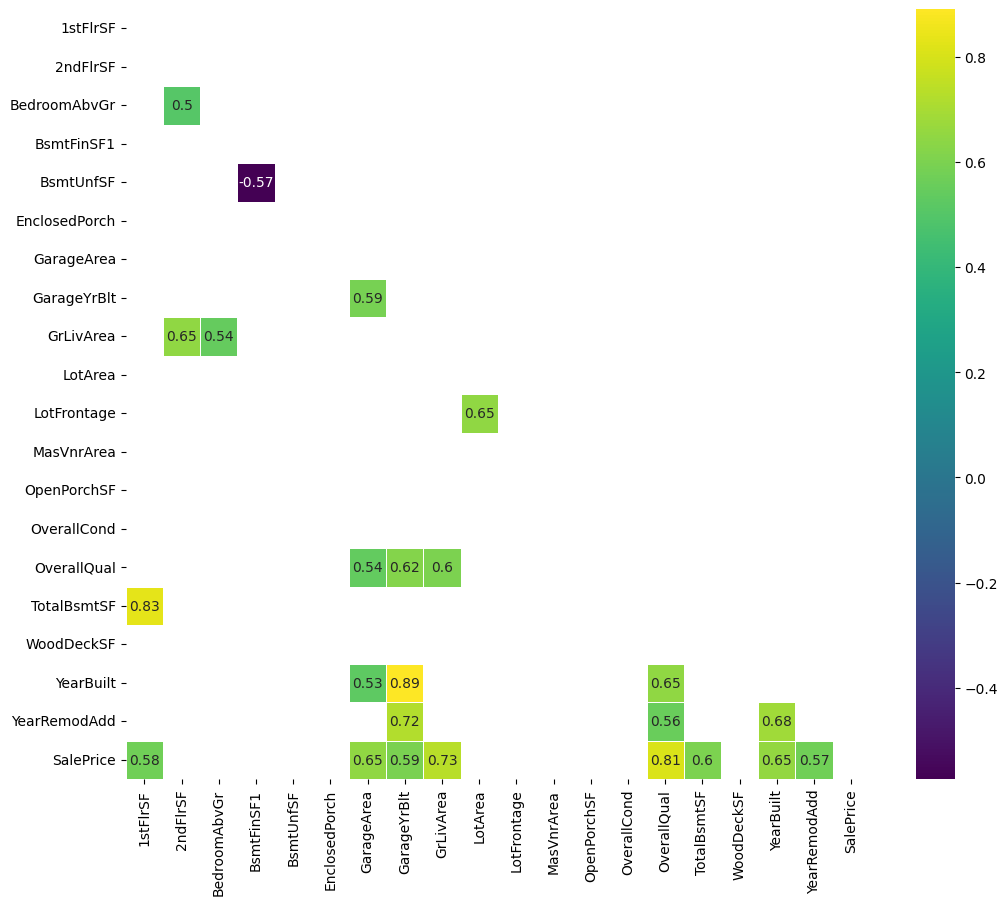



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



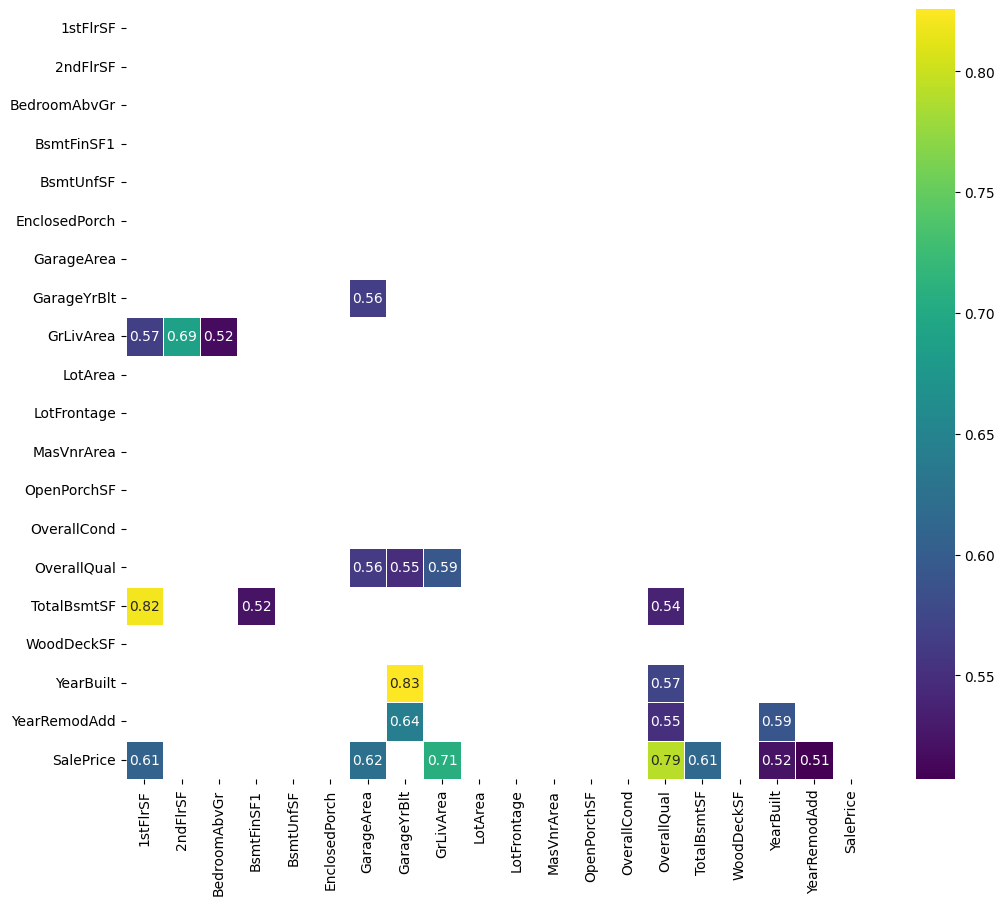



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



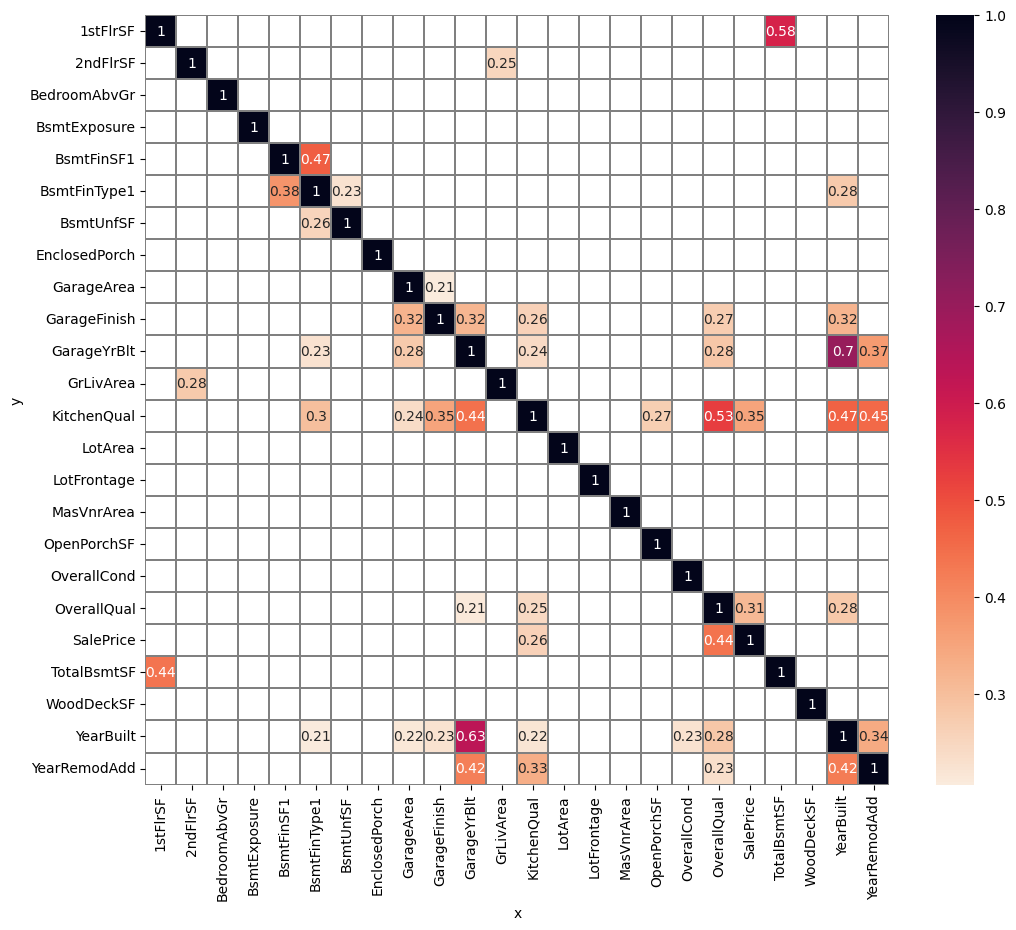

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.5, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

___

## Further Data Analysis
### Missing data analysis

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data


In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


In [12]:
EvaluateMissingData(df_inherited)

,RowsWithMissingData,PercentageOfDataset,DataType


##### Results of missing data evaluation

* As we can see we have 9 columns that contain missing data, with both EnclosedPorch and WoodDeckSF having a hugely significant portion of their data missing.
* The other columns do not have nearly as much missing data as the previously mentioned two, however the amount if missing data is still an issue.
* The brightside here is that none of the features that were intially flagged as potentially important in the previous notebook appear in this list.

#### Effects of data cleaning methods

* In the previous notebook we completed some very simple data cleaning just to get a rough look at what effect it would have on the features that we identefied as potentally important. We wanted to see there that if after some simple cleaning and engineering whether those features remained the most important.
* The above PPS and correlation tests have then reinforced that based on the raw data we collected the top features that look to be able to predict SalePrice are:
    1. A large 1st floor square footage. (1stFlrSF)
    2. A large garage square footage. (GarageArea)
    3. A large above grade (ground) living area square footage. (GrLivArea)
    4. A high overall quality. (OverallQual)
    5. A large basement square footage. (TotalBsmtSF)
    6. A house built more recently. (YearBuilt)


* What we shall now look at is a more in-depth look into the effects of different data cleaning methods, The code below has been taken from the Code Institute Lessons relating to Predictive Analytics.
    * The below function assess the effect of different data cleaning methods such replacing missing numerical values with the Mean or the Median, and replacing Categorical values with 'Missing' or the most frequently seen value. 
    * Once we have gone through and cleaned our data producing a new cleaned dataframe we shall use this function to evaluate any significant changes to the original. 

In [13]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate the plot number
  
  # Distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over the variables, 
    # first on variables that you applied to the method
    # if the variable is numerical plot a histogram, if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

___

## Data Cleaning

* We can start the cleaning process by returning to an earlier function and pulling our columns that contain missing data.

In [14]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


* As previously stated both EnclosedPorch and WoodDeckSF have an extreamly high percentage of null values. It is therefore not viable to attempt to impute any values in place of these, for this reason we shall be dropping these columns entirely from our dataset.
* LotFrontage and GarageFinish also have a high percentage of null values. Both above 10%. They shall not be immediatly dropped without evaluation however as they may still provide insights after data cleaning.
* The remaining 5 variables will all be cleaned and evaluated using the function defined above.

* It is my assumption that due to the fact none of these variables have been flagged in any data analysis as potentially useful for predicting SalesPrice that after data cleaning they will still prove to be unimportant, however we can not confirm this assumption without performing the relevent data cleaning and subsequent evaluation. The only 2 exceptoions to this are EnclosedPorch and WoodDeckSF. Both of which are float64 variables with 90% null values meaning any mean, median or arbitary number imputation would not be close to a relistic representation of the data and will not aid in our predictions and could even have a negative impact if any.

#### Data cleaning we will try initially
1. Drop - ['EnclosedPorch', 'WoodDeckSF' ]
2. Arbitary Number Imputer - ['2ndFlrSF', 'BedroomAbvGr', 'MasVnrArea'] 
3. Impute the Mean - ['LotFrontage', 'GarageYrBlt' ]
4. Impute 'Missing' - ['GarageFinish', 'BsmtFinType1' ]

___

## Splt the cleaned data

The first step when cleaning is to create a copy of our dataset.

In [15]:
df_clean = df.copy()
print(df_clean.shape)

(1460, 24)


We then split our original dataset into train and test sets.

In [16]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


We can now evaluate the spread of missing values with in the test set that we have just created.

In [17]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


* Upon reviweing the test set we can see the split is extrealy similar to the split of the raw data. As expected the same 9 variables have been flagged with a slight decrease in the the percantage of missing data, however we still see theat EnclosedPorch and WoodDeckSF have 90.41% and 88.53% missing data respectivly so we shall copntinue to work on the assumption that they will be of no help in answering the business requiremets and will be dropped due to this.

___

### Step 1 of data cleaning

* As stated above we want to drop EnclosedPorch and WoodDeckSF as they have a large majority of null values and will likely not effect our predictions in any meaningful way.
* In order to achieve this we will run the following code, utilising the DropFeatures meathod from feature_engine and will apply this change to both the train and test set.

In [18]:
from feature_engine.selection import DropFeatures
variables = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)
TestSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
529,2515,0.0,4.0,No,1219,Rec,816,484,NaN,1975.0,2515,TA,32668,NaN,NaN,0,3,6,2035,1957,1975,200624
491,958,620.0,3.0,No,403,BLQ,238,240,Unf,1941.0,1578,Fa,9490,79.0,0.0,0,7,6,806,1941,1950,133000
459,979,224.0,3.0,No,185,LwQ,524,352,Unf,1950.0,1203,Gd,7015,NaN,161.0,0,4,5,709,1950,1950,110000
279,1156,866.0,4.0,No,392,BLQ,768,505,Fin,1977.0,2022,TA,10005,83.0,299.0,117,5,7,1160,1977,1977,192000
655,525,NaN,3.0,No,0,Unf,525,264,Unf,1971.0,1092,TA,1680,21.0,381.0,0,5,6,525,1971,1971,88000


In [19]:
df_clean = imputer.transform(df_clean)

We can check again that our code worked by placing all columns with null values into a list, as we can see EnclosedPorch and WoodDeckSF are no longer present as they have been dropped.

In [20]:

null_variables = TrainSet.columns[TrainSet.isnull().any()].tolist()
print(null_variables)

['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']


In [21]:
EvaluateMissingData(df_clean)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


___

### Step 2 of Data cleaning

As stated above we have a large list of columns all of which were float64 variables, that we, as a base defined imputing the mean as a potential solution. However uponm inspection of the data, we can deduce that imputing the mean my not be the most optimum solution.
The float64 variables are: ['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'] 

After looking closly at the raw data set we can make some assumptions about the missing data which will help in our data cleaning.
* The first thing I noticed when looking more deeply into our data is that 2ndFlrSF has a very large amount of 0 values (626 rows). We can assume this is due to the propertty being a bungalow and therefore having no second floor area. Further more the null value count is relativy low (60 rows), for this reason we can safely assume that if we convert our null values to 0 values we will not negatively impact our data.
* Secondly BedroomAbvGr is a grading system of bedrooms from 0-8. On first impressions it looks like there is no accurate way to remove the null values, our heat map shows that there are no other variables with the ability to predict BedroomAbvGr and imputing the mean or median would be inaccurate and could negatively effect our predictions. However when we look at our Inherited_df (the data we want to predict). We can see that all the houses have an BedroomAbvGr > 0. Due to this we can set all our null values to 0 using ArbitaryNumberImputer just like 2nfFlrSF.
* Thirdly MasVnrArea follows a very similar trend to 2ndFlrSF. It has a very high count of 0 values. Which to me indicates that these houses have no Masonry Veneer. Furthermore in terms of the null value count there are only 8 rows with null values. Due to these reasons and the fact that the heat map showed no predictive power for MasVnrArea I am confident we may also impute 0 for null values in this field without negatively impacting our predictions.

In [22]:
TrainSet['2ndFlrSF'].value_counts().sort_index()

0.0       626
110.0       1
167.0       1
192.0       1
208.0       1
         ... 
1540.0      1
1611.0      1
1796.0      1
1818.0      1
1872.0      1
Name: 2ndFlrSF, Length: 345, dtype: int64

In [23]:
TrainSet['BedroomAbvGr'].value_counts().sort_index()

0.0      4
1.0     32
2.0    266
3.0    599
4.0    166
5.0     16
6.0      4
8.0      1
Name: BedroomAbvGr, dtype: int64

In [24]:
TrainSet['MasVnrArea'].value_counts().sort_index()

0.0       698
1.0         2
11.0        1
14.0        1
16.0        7
         ... 
1115.0      1
1129.0      1
1170.0      1
1378.0      1
1600.0      1
Name: MasVnrArea, Length: 282, dtype: int64

In [25]:
pipeline = Pipeline([
    ('2ndFlrSF_BedrromAbvGr_MasVnrArea', ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'BedroomAbvGr', 'MasVnrArea']))
])
pipeline.fit(TrainSet)
TrainSet, TestSet = pipeline.transform(TrainSet), pipeline.transform(TestSet)
df_clean = pipeline.transform(df_clean)
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
GarageYrBlt,58,4.97,float64


As we can see when we evaluate missing data in our train set 2ndFlrSF, BedroomAbvGr and MasVnrArea are no longer present. To double check our pipeline worked we will also check the missing values in our clean dataframe.

In [26]:
EvaluateMissingData(df_clean)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
GarageYrBlt,81,5.55,float64


___

### Step 3 of Data cleaning

As we can see we have 4 columns left that conntain null values and require cleaning. The next one that I belive will be easily sorted is LotFrontage.

In [27]:
TrainSet['LotFrontage'].value_counts().sort_index()

21.0     17
24.0     16
30.0      6
32.0      4
33.0      1
         ..
153.0     1
168.0     1
174.0     1
182.0     1
313.0     1
Name: LotFrontage, Length: 104, dtype: int64

Looking at the LotFrontage data we can see it contains 212 rows of missing data. (Just under 18%)
The values range from 21.0 to 313.0. If we go back and look at the Pandas Profiling report we can see that the mean is 70.05 if we round to 2 decimal places and it has no 0 values. My first impression is to use to Impute the mean using MeanMedainImputer to all null values. Again we can see from the heat map LotFrontage holds no predictive power so we shouldn't have to worry about negative impacts to our predictions. 

In [30]:
mean_imputer = MeanMedianImputer(imputation_method='mean', variables=['LotFrontage'])
mean_imputer.fit(TrainSet)
TrainSet, TestSet = mean_imputer.transform(TrainSet), mean_imputer.transform(TestSet)
df_clean = mean_imputer.transform(df_clean)
EvaluateMissingData(TrainSet)


,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
GarageYrBlt,58,4.97,float64


Again upon inspection we can see our last 3 variables that contain null values, indicting our code worked on LotFrontage. We will test again though on the clean dataframe.

In [32]:
EvaluateMissingData(df_clean)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
GarageYrBlt,81,5.55,float64


___

### Step 4 of Data cleaning

The next variable to look at is BsmtFinType1 which is an object variable refering to the state of the basement that is finished. The first thing to do is inspect the varible itself. We already know that within our test set there are 89 rows containing missing data. We also know that from reviewing the heatmap that BsmtFinSF1 could be used to predict BsmtFinType1. We also have a lot of other variables that refer to the basement. For example TotalBsmtSF, it stands to reason that any house with a TotalBsmtSF that equals 0 does not have a basement. Therefore The BsmtFinType1 should equal 'None', we can query this and make sure this is true.

In [33]:

TrainSet['BsmtFinType1'].value_counts().sort_index()

ALQ     159
BLQ     114
GLQ     303
LwQ      52
None     25
Rec     100
Unf     326
Name: BsmtFinType1, dtype: int64

In [35]:
TrainSet[TrainSet['BsmtFinType1'].isna()].query('TotalBsmtSF==0').sort_values(by=['TotalBsmtSF'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
90,1040,0.0,2.0,None,0,NaN,0,420,Unf,1950.0,1040,TA,7200,60.0,0.0,29,5,4,0,1950,1950,109900
736,1040,0.0,2.0,None,0,NaN,0,400,Unf,1949.0,1040,TA,8544,60.0,0.0,0,4,3,0,1950,1950,93500
1179,1124,0.0,3.0,None,0,NaN,0,0,None,NaN,1124,TA,8335,77.0,0.0,36,5,5,0,1954,1954,93000


As we can see 3 properties have 0 TotalBsmtSF and missing data, we can impute 'None' for these values.

In [37]:
train_query_condition = (TrainSet.TotalBsmtSF == 0) & (TrainSet['BsmtFinType1'].isnull())
TrainSet['BsmtFinType1'] = np.where(train_query_condition, 'None', TrainSet['BsmtFinType1'])

test_query_condition = (TestSet.TotalBsmtSF == 0) & (TestSet['BsmtFinType1'].isnull())
TestSet['BsmtFinType1'] = np.where(test_query_condition, 'None', TestSet['BsmtFinType1'])

df_clean_query_condition = (df_clean.TotalBsmtSF == 0) & (df_clean['BsmtFinType1'].isnull())
df_clean['BsmtFinType1'] = np.where(df_clean_query_condition, 'None', df_clean['BsmtFinType1'])

In [38]:
TrainSet[TrainSet['BsmtFinType1'].isna()].query('TotalBsmtSF==0').sort_values(by=['TotalBsmtSF'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice


In [39]:
TrainSet['BsmtFinType1'].isna().sum()

86

As we can see from our two tests, we have imputed None into our 3 rows and they no longer appear when we query TotalBsmtSF = 0 and null values. we can also see our total rows with null values has decreased by 3 to a total of 86.

In a similar method to our previous 3 rows, we shall query the null values of BsmtFinType1 against BsmtFinSF1. the aformentioned variable describes the surface area of the basement that is finished. if the value of this is 0 then we can conclude that the basment is unfinished and therefore we can impute 'Unf' into our null values.

In [40]:
TrainSet[TrainSet['BsmtFinType1'].isna()].query('BsmtFinSF1==0').sort_values(by=['BsmtFinSF1'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
431,1088,110.0,4.0,No,0,NaN,901,0,NaN,NaN,1198,TA,5586,60.000000,0.0,98,7,6,901,1920,1998,79900
1342,1284,885.0,3.0,No,0,NaN,1284,647,RFn,2002.0,2169,Gd,9375,69.614017,149.0,87,5,8,1284,2002,2002,228500
584,989,584.0,3.0,No,0,NaN,884,240,Unf,1935.0,1573,Gd,6120,51.000000,0.0,0,7,4,884,1935,1995,133000
890,672,252.0,0.0,Mn,0,NaN,672,576,Unf,2003.0,924,TA,8064,60.000000,0.0,0,7,5,672,1949,2006,122900
573,774,656.0,3.0,No,0,NaN,384,400,RFn,2000.0,1430,TA,9967,76.000000,0.0,0,5,7,384,2000,2000,170000
653,756,713.0,3.0,No,0,NaN,756,216,Unf,1906.0,1469,TA,10320,60.000000,0.0,0,7,6,756,1906,1995,135000
248,840,828.0,3.0,No,0,NaN,840,500,RFn,2003.0,1668,Gd,11317,72.000000,101.0,68,5,7,840,2003,2003,180000
1219,672,546.0,3.0,No,0,NaN,672,0,None,NaN,1218,TA,1680,21.000000,236.0,0,5,6,672,1971,1971,91500
374,847,1081.0,4.0,No,0,NaN,847,434,Fin,2003.0,1928,Gd,8200,65.000000,0.0,48,5,7,847,2003,2004,219500
22,1795,0.0,3.0,No,0,NaN,1777,534,RFn,2002.0,1795,Gd,9742,75.000000,281.0,159,5,8,1777,2002,2002,230000


In [41]:
unf_df = TrainSet[TrainSet['BsmtFinType1'].isna()].query('BsmtFinSF1==0').sort_values(by=['BsmtFinSF1'])
print(unf_df.shape)

(27, 22)


As we can see we have 27 rows where we can conclude that the Basment is unfinished.

In [42]:
train_query_condition = (TrainSet.BsmtFinSF1 == 0) & (TrainSet['BsmtFinType1'].isnull())
TrainSet['BsmtFinType1'] = np.where(train_query_condition, 'Unf', TrainSet['BsmtFinType1'])

test_query_condition = (TestSet.BsmtFinSF1 == 0) & (TestSet['BsmtFinType1'].isnull())
TestSet['BsmtFinType1'] = np.where(test_query_condition, 'Unf', TestSet['BsmtFinType1'])

df_clean_query_condition = (df_clean.BsmtFinSF1 == 0) & (df_clean['BsmtFinType1'].isnull())
df_clean['BsmtFinType1'] = np.where(df_clean_query_condition, 'Unf', df_clean['BsmtFinType1'])

In [43]:
TrainSet[TrainSet['BsmtFinType1'].isna()].query('BsmtFinSF1==0').sort_values(by=['TotalBsmtSF'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice


In [44]:
TrainSet['BsmtFinType1'].isna().sum()

59

Again we can see that our null values are dropping as we are imputing values. and we are left with 59 rows with null values.
* The question is now how do we define these null values. As stated earlier there are other factors that can be used to predict BsmtFinType1. However the work needed to produce a model that could accurately predict BsmtFinType1 would be great and would it add value to our business requirements? Looking at the heatmap and correlation we can see that BsmtFinType1 has no correlation to SalesPrice and does not hold any predictive power towards it. Therefore I assume that there is no real need to get a accurate value for these remaining rows. For this reason we will simply use the CatergoricalImputer to place 'Unknown' in place of these values.


In [45]:
unknown_imputer = CategoricalImputer(
    imputation_method='missing', fill_value='Unknown', variables='BsmtFinType1'
    )
unknown_imputer.fit(TrainSet)
TrainSet, TestSet, df_clean = unknown_imputer.transform(TrainSet), unknown_imputer.transform(TestSet), unknown_imputer.transform(df_clean)

In [47]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,131,11.22,object
GarageYrBlt,58,4.97,float64


As we can see we have our final 2 variables left to clean. These have been left till last as they both refer to the garage and like woth the BsmtFinType1 we may see links that help us impute accurate data for the null values.

___

### Step 5 of Data cleaning

The first variable out of the final two we shall look at is GarageFinish, which is an object variable that refers to the state of the garage. First we shall inspect the data. We already know from above that there are 131 rows with missing data.

In [50]:
TrainSet['GarageFinish'].value_counts().sort_index()

Fin     254
None     53
RFn     293
Unf     437
Name: GarageFinish, dtype: int64

Similarly to the method used when cleaning BsmtfinType1, we shall use another variable to infer information about the GarageFinish. If we look at GarageArea, we can assume that if GarageArea equals 0 then GarageFinish shoudl equal 'None'. 

In [52]:
TrainSet[TrainSet['GarageFinish'].isna()].query('GarageArea==0').sort_values(by=['GarageArea'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
431,1088,110.0,4.0,No,0,Unf,901,0,NaN,NaN,1198,TA,5586,60.0,0.0,98,7,6,901,1920,1998,79900
528,605,0.0,2.0,Mn,348,Unknown,180,0,NaN,NaN,605,TA,9098,58.0,0.0,0,7,4,528,1920,2002,86000
125,520,0.0,2.0,Av,490,GLQ,30,0,NaN,NaN,754,TA,6780,60.0,0.0,0,8,6,520,1935,1982,84500
1325,796,0.0,2.0,No,0,Unf,796,0,NaN,NaN,796,TA,3636,40.0,0.0,0,4,4,796,1922,1950,55000
710,729,0.0,2.0,No,0,Unf,270,0,NaN,NaN,729,TA,4130,56.0,0.0,0,6,3,270,1935,2003,52000


We can see we have 5 rows where GarageFinish is null and GarageArea equals 0. Like before we shall impute 'None' into these rows.

In [53]:
train_query_condition = (TrainSet.GarageArea == 0) & (TrainSet['GarageFinish'].isnull())
TrainSet['GarageFinish'] = np.where(train_query_condition, 'None', TrainSet['GarageFinish'])

test_query_condition = (TestSet.GarageArea == 0) & (TestSet['GarageFinish'].isnull())
TestSet['GarageFinish'] = np.where(test_query_condition, 'None', TestSet['GarageFinish'])

df_clean_query_condition = (df_clean.GarageArea == 0) & (df_clean['GarageFinish'].isnull())
df_clean['GarageFinish'] = np.where(df_clean_query_condition, 'None', df_clean['GarageFinish'])

In [54]:
TrainSet[TrainSet['GarageFinish'].isna()].query('GarageArea==0').sort_values(by=['GarageArea'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice


In [56]:
TrainSet['GarageFinish'].isna().sum()

126

As we can see our count of null values has reduced by 5 indicating our code has worked. We can double check that 'None' has increased by 5 by running the following code.

In [57]:
TrainSet['GarageFinish'].value_counts().sort_index()

Fin     254
None     58
RFn     293
Unf     437
Name: GarageFinish, dtype: int64

Unfortuantly there are no other variables that we can use that will give insight into the GarageFinish. And after a review of the PPS heatmap we can see that GarageFinihs holds no predictive power on the business requirement (SalesPrice). For this reason we shall again impute 'Unknown' to the rest of the null values for GarageFinish. 

In [58]:
unknown_imputer = CategoricalImputer(
    imputation_method='missing', fill_value='Unknown', variables='GarageFinish'
    )
unknown_imputer.fit(TrainSet)
TrainSet, TestSet, df_clean = unknown_imputer.transform(TrainSet), unknown_imputer.transform(TestSet), unknown_imputer.transform(df_clean)

In [59]:
TrainSet['GarageFinish'].value_counts().sort_index()

Fin        254
None        58
RFn        293
Unf        437
Unknown    126
Name: GarageFinish, dtype: int64

In [60]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageYrBlt,58,4.97,float64


As we can see we now have our 'Unknown' values in GarageFinish, and upon evaluating the missing data the only variable left is GarageYrBlt.

___

### Step 6 of Data cleaning

The final Variable to be cleaned is GarageYrBlt, which refers to the year in which the garage is built, it is a float64 variable with 58 null values.

In [61]:
TrainSet['GarageYrBlt'].value_counts().sort_index()

1900.0     1
1906.0     1
1908.0     1
1910.0     2
1914.0     2
          ..
2006.0    46
2007.0    37
2008.0    23
2009.0    16
2010.0     3
Name: GarageYrBlt, Length: 97, dtype: int64

We can make the assumption that a null value is GarageyrBlt indicates that there is no garage. If that is the case then GarageFinish should equal None at the same instance that we have our null values. We can test this by running the code below.

In [64]:
query_df = TrainSet[TrainSet['GarageYrBlt'].isna()].query('GarageFinish=="None"').sort_values(by=['GarageFinish'])
print(query_df.shape)

(58, 22)


As we can see the code has returned the shape of the dataframe produced by our query. The shape shows that there are 58 rows where GarageFinish is 'None' and GarageYrBlt is null proving our assumption.
We shall use Arbitary Number Imputer to place 0 into the null values reflecting the fact that no garage has been built.

In [68]:
pipeline = Pipeline([
      ( 'GarageYrBlt',  ArbitraryNumberImputer(
        arbitrary_number=0, variables='GarageYrBlt'
        ) 
      )
])
pipeline

pipeline.fit(TrainSet)
TrainSet, TestSet, df_clean = pipeline.transform(TrainSet), pipeline.transform(TestSet),pipeline.transform(df_clean)

In [69]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


In [67]:
EvaluateMissingData(df_clean)

,RowsWithMissingData,PercentageOfDataset,DataType


As we can see after our previous two cells we have cleaned all the data and have no null values left in our data.

___

### Comparison 

Now that we have removed all null values in our cleaned dataframe, train and test sets. we can utilise the DataCleaningEffect function that we defined earlier on in this notebook.
* This function plots our original dataframe against our clean dataframe so we can see the effect of our data cleaning.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'] 




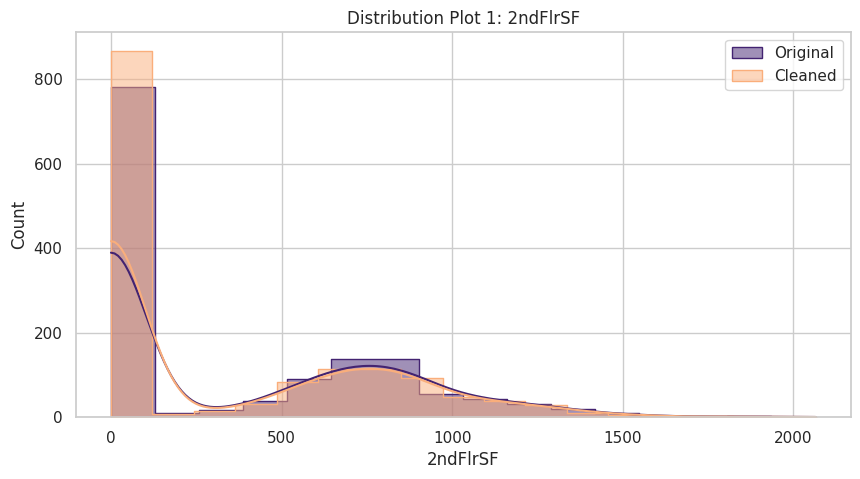

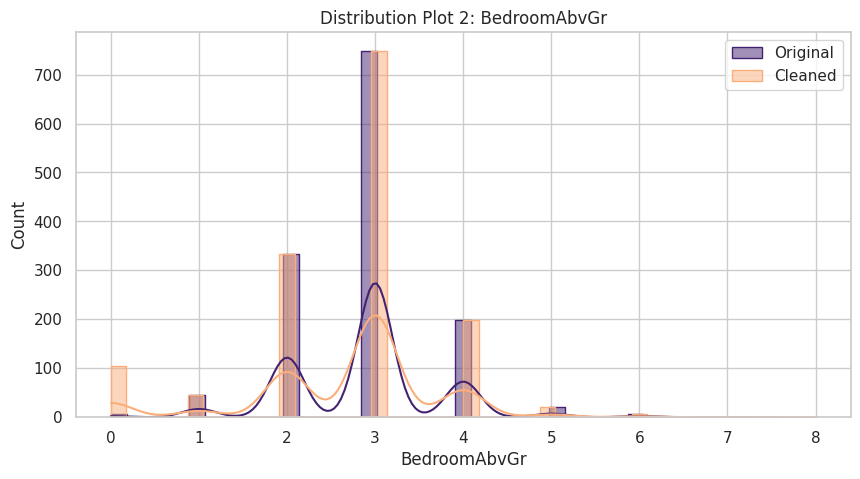

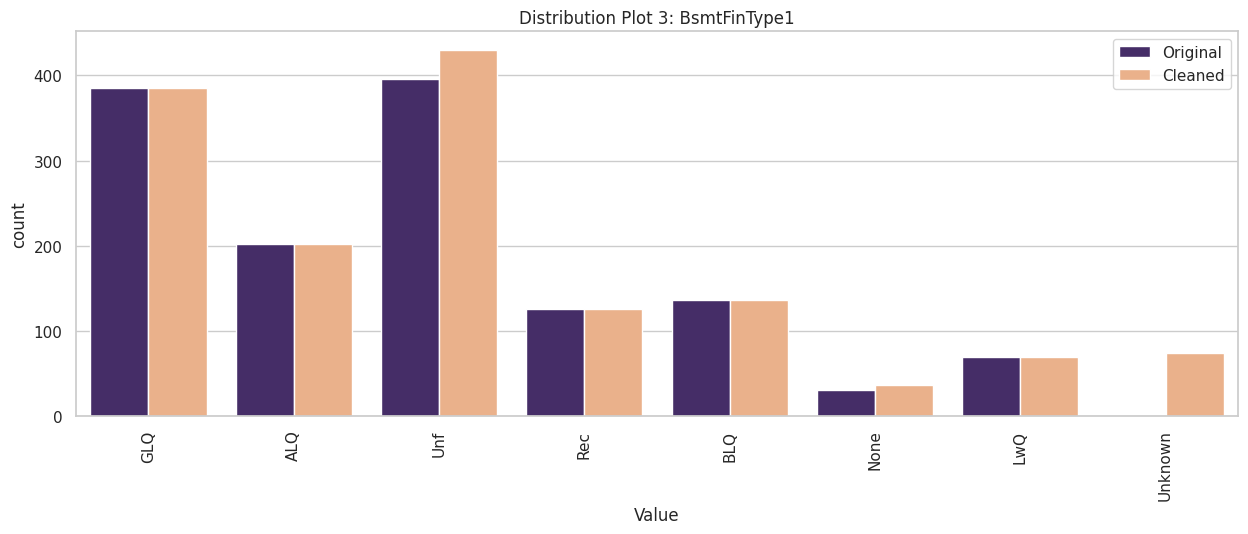

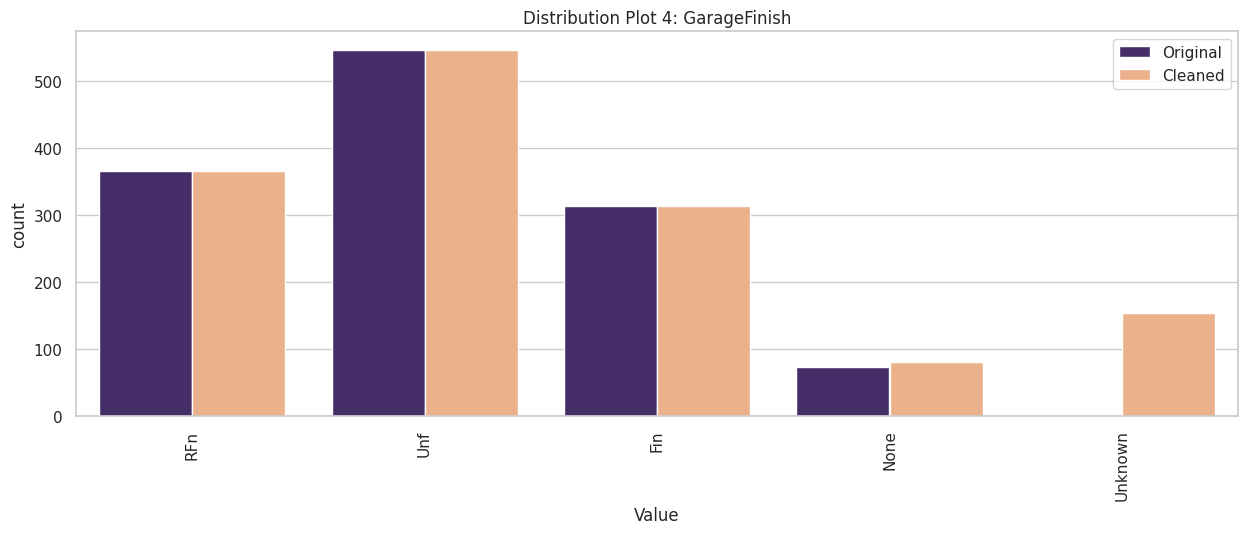

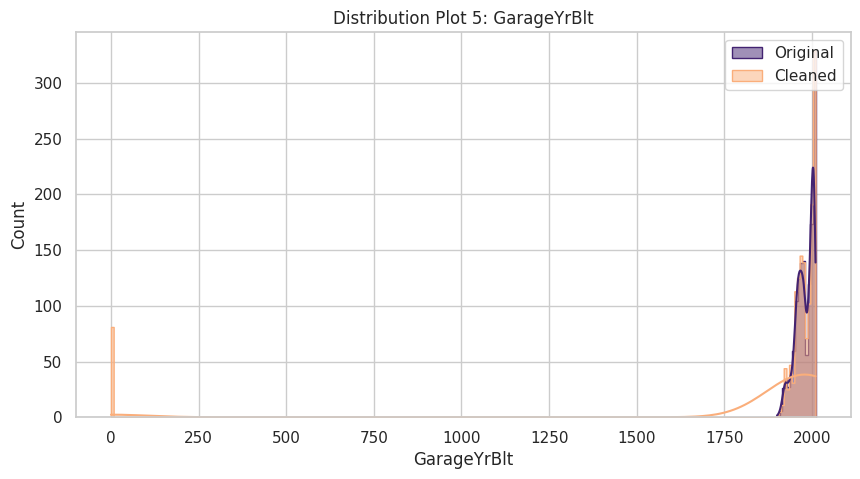

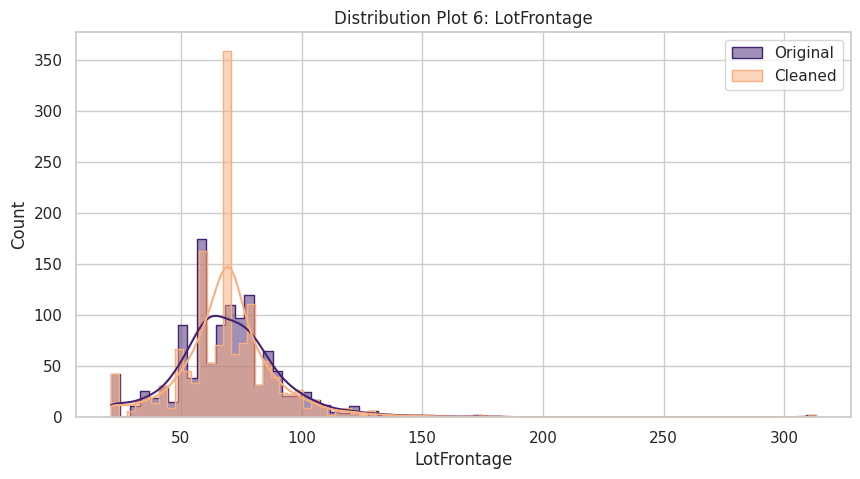

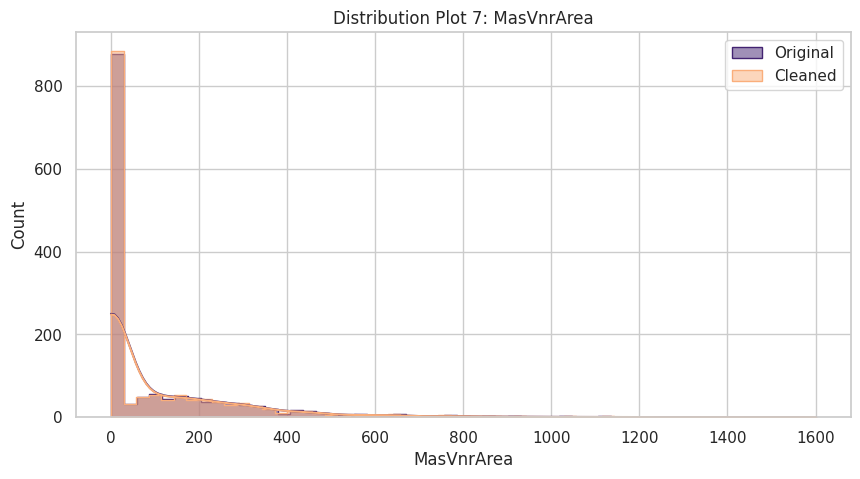

In [70]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_clean,
                   variables_applied_with_method=null_variables)

* Looking at the effect on the distribution of these variables we can see a bit more of s peak at LotFrontage where we imputed the mean.
* The GarageYrBlt is skewed heavily due to the addition of 0 values.
* Everything else has remained verey similar.

___

### Match Datatypes across df_clean and df_inherited

In [74]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   float64
 2   BedroomAbvGr  1460 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

In [75]:
df_inherited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       4 non-null      int64  
 1   2ndFlrSF       4 non-null      int64  
 2   BedroomAbvGr   4 non-null      int64  
 3   BsmtExposure   4 non-null      object 
 4   BsmtFinSF1     4 non-null      float64
 5   BsmtFinType1   4 non-null      object 
 6   BsmtUnfSF      4 non-null      float64
 7   EnclosedPorch  4 non-null      int64  
 8   GarageArea     4 non-null      float64
 9   GarageFinish   4 non-null      object 
 10  GarageYrBlt    4 non-null      float64
 11  GrLivArea      4 non-null      int64  
 12  KitchenQual    4 non-null      object 
 13  LotArea        4 non-null      int64  
 14  LotFrontage    4 non-null      float64
 15  MasVnrArea     4 non-null      float64
 16  OpenPorchSF    4 non-null      int64  
 17  OverallCond    4 non-null      int64  
 18  OverallQual   

In [81]:
print(df_clean.select_dtypes('object').info())
print(df_clean.select_dtypes('float').info())
print(df_clean.select_dtypes('int').info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtExposure  1460 non-null   object
 1   BsmtFinType1  1460 non-null   object
 2   GarageFinish  1460 non-null   object
 3   KitchenQual   1460 non-null   object
dtypes: object(4)
memory usage: 45.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   2ndFlrSF      1460 non-null   float64
 1   BedroomAbvGr  1460 non-null   float64
 2   GarageYrBlt   1460 non-null   float64
 3   LotFrontage   1460 non-null   float64
 4   MasVnrArea    1460 non-null   float64
dtypes: float64(5)
memory usage: 57.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  D

In [80]:
print(df_inherited.select_dtypes('object').info())
print(df_inherited.select_dtypes('float').info())
print(df_inherited.select_dtypes('int').info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtExposure  4 non-null      object
 1   BsmtFinType1  4 non-null      object
 2   GarageFinish  4 non-null      object
 3   KitchenQual   4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BsmtFinSF1   4 non-null      float64
 1   BsmtUnfSF    4 non-null      float64
 2   GarageArea   4 non-null      float64
 3   GarageYrBlt  4 non-null      float64
 4   LotFrontage  4 non-null      float64
 5   MasVnrArea   4 non-null      float64
 6   TotalBsmtSF  4 non-null      float64
dtypes: float64(7)
memory usage: 352.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Da

By running the above code we can see there are some discrepencies in the data types between the cleaned dataframe and inherited dataframe. We want to rectify this that the data types are like for like across dataframes.
* All the object type variables are the same so require no change.
* There are 5 float64 variables in df_clean and 7 in df_inherited.
* There there are 13 int64 variables in df_clean and 12 in df_inherited.
* For ease we will change all floats to ints. This will then be repeated in the train and test sets.

In [82]:
for col in df_clean.select_dtypes('float').columns:
    df_clean[col] = df_clean[col].astype('int64')

for col in df_inherited.select_dtypes('float').columns:
    df_inherited[col] = df_inherited[col].astype('int64')

print(df_clean.select_dtypes('float').info())
print(df_inherited.select_dtypes('float').info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Empty DataFrame
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Empty DataFrame
None


As we can see there are now no more float variables, we can check our dataframes as a whole to make sure everthing worked as expected and the floats have become int64

In [83]:
print(df_clean.info())
print(df_inherited.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   1stFlrSF      1460 non-null   int64 
 1   2ndFlrSF      1460 non-null   int64 
 2   BedroomAbvGr  1460 non-null   int64 
 3   BsmtExposure  1460 non-null   object
 4   BsmtFinSF1    1460 non-null   int64 
 5   BsmtFinType1  1460 non-null   object
 6   BsmtUnfSF     1460 non-null   int64 
 7   GarageArea    1460 non-null   int64 
 8   GarageFinish  1460 non-null   object
 9   GarageYrBlt   1460 non-null   int64 
 10  GrLivArea     1460 non-null   int64 
 11  KitchenQual   1460 non-null   object
 12  LotArea       1460 non-null   int64 
 13  LotFrontage   1460 non-null   int64 
 14  MasVnrArea    1460 non-null   int64 
 15  OpenPorchSF   1460 non-null   int64 
 16  OverallCond   1460 non-null   int64 
 17  OverallQual   1460 non-null   int64 
 18  TotalBsmtSF   1460 non-null   int64 
 19  YearBu

With everything working as expected we will now apply the same change sto the train and test sets.

In [84]:
for col in TrainSet.select_dtypes('float').columns:
    TrainSet[col] = TrainSet[col].astype('int64')

for col in TestSet.select_dtypes('float').columns:
    TestSet[col] = TestSet[col].astype('int64')

print(TrainSet.info())
print(TestSet.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   1stFlrSF      1168 non-null   int64 
 1   2ndFlrSF      1168 non-null   int64 
 2   BedroomAbvGr  1168 non-null   int64 
 3   BsmtExposure  1168 non-null   object
 4   BsmtFinSF1    1168 non-null   int64 
 5   BsmtFinType1  1168 non-null   object
 6   BsmtUnfSF     1168 non-null   int64 
 7   GarageArea    1168 non-null   int64 
 8   GarageFinish  1168 non-null   object
 9   GarageYrBlt   1168 non-null   int64 
 10  GrLivArea     1168 non-null   int64 
 11  KitchenQual   1168 non-null   object
 12  LotArea       1168 non-null   int64 
 13  LotFrontage   1168 non-null   int64 
 14  MasVnrArea    1168 non-null   int64 
 15  OpenPorchSF   1168 non-null   int64 
 16  OverallCond   1168 non-null   int64 
 17  OverallQual   1168 non-null   int64 
 18  TotalBsmtSF   1168 non-null   int64 
 19  YearB

___

### Finally we can save our clean dataframe and our train and test sets

In [ ]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

In [ ]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSet.csv", index=False)

In [ ]:
TestSet.to_csv("outputs/datasets/cleaned/TestSet.csv", index=False)

In [ ]:
df_clean.to_csv("outputs/datasets/cleaned/clean_house_price_records.csv", index=False)

In [ ]:
df_inherited.to_csv("outputs/datasets/cleaned/clean_inherited_houses.csv", index=False)

___

### Conclusion

In conclusion as we have worked through this workbook we have:
* Further analysed our data to identify variables that required cleaning and gave thought to what would be the optimum method to do so.
* we split our data into a train and test set.
* We dropped varibales that we deemed unimportant to our business goal.
* We stepped through each of our variables containing null values and cleaned them, replacing null values with values that best suited the data.
* We then evaluated our data cleaning against the original data.
* Finally we ensured that the clean data frame, test and train set and the inherited dataframe all had the same data types across all variables.